In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
from scipy.stats import mannwhitneyu, ttest_ind
from tqdm import tqdm
import numpy as np 
import math
%matplotlib inline
def process_unis():
    unis = pd.read_csv('../../data/IPEDS/university_info/hd2021.csv', encoding='cp1252')
    ## Preprocessing meta-data files
    ### Updating names to match in rankings  
    unis.loc[unis['IALIAS']=='Virginia Tech', 'INSTNM'] = 'Virginia Tech'
    unis.loc[unis['INSTNM']=='University of Illinois Urbana-Champaign', 'INSTNM'] = 'University of Illinois at Urbana-Champaign'
    unis.loc[(unis['INSTNM']=="St. John's College") & (unis['STABBR']=='MD'), 'INSTNM'] = "St. John's College - MD"
    unis.loc[(unis['INSTNM']=="St. John's College") & (unis['STABBR']=='NM'), 'INSTNM'] = "St. John's College - NM"
    unis.loc[unis['INSTNM']=="William & Mary", 'INSTNM'] = "College of William and Mary"
    unis.loc[(unis['INSTNM']=="Brigham Young University") & (unis['CITY']=='Provo'), 'INSTNM'] = "Brigham Young University-Provo"
    unis.loc[(unis['INSTNM']=="The University of the South") & (unis['CITY']=='Sewanee'), 'INSTNM'] = "Sewanee - The University of the South"
        
    return unis

def process_completions(year):
    completions = pd.read_csv('../../data/IPEDS/completions/c%s_a.csv' % year)
    return completions
# hard coded it because of assignment errors

In [3]:
def startup():
    all_unis = {}
    all_completions = {}
    for year in range(2008, 2022):
        all_unis[year] = process_unis()
        all_completions[year] = process_completions(year)
    cols = ['UNITID', 'CTOTALW', 'CAIANT', 'CBKAAT', 'CHISPT']
    return all_unis, all_completions, cols

In [4]:
def region_processing(uni_data, completion_data, region):
    uni_boolmap = uni_data['OBEREG'] == region
    region_unis = uni_data[uni_boolmap]
    unitids = set(region_unis['UNITID'])
    completion_boolmap = completion_data['UNITID'].apply(lambda x: x in unitids)
    region_data = completion_data[completion_boolmap]
    return region_data, region_unis

In [5]:
reg_code_to_label = {0: 'US Service Schools', 1: 'New England', 2: 'Mid East', 3: 'Great Lakes', 4: 'Plains',\
     5: 'Southeast',6: 'Southwest', 7: 'Rocky Mountains',8: 'Far West', 9: 'Outlying Areas'}

In [6]:
def make_years(completions, unis, region, start, end):
    years = {}
    for year in range(start, end + 1):
        year_completions, year_unis = region_processing(unis[year], completions[year], region)
        years[year] = [year_completions, year_unis]
    return years

In [7]:
# data is the dataframe already boolmapped with the proper data
def groupTotals(years):
    allStateCsData  = []
    allStateNonCsData = []
    for year in years:
        data, unis = years[year]
        csMerge, nonCsMerge = csVsNonCs(data, unis)
        csMerge['year'] = year
        nonCsMerge['year'] = year
        allStateCsData.append(csMerge)
        allStateNonCsData.append(nonCsMerge)
    allStateCsData = pd.concat(allStateCsData)
    allStateNonCsData = pd.concat(allStateNonCsData)
    return allStateCsData, allStateNonCsData
    
        
        
def csVsNonCs(data, unis):
    csBoolmap = data['CIPCODE'].apply(lambda x : x < 12 and x >= 11)
    cs = data[csBoolmap]
    csSum = cs.groupby('UNITID').sum()
    csSum = csSum.reset_index()
    uniqueIds = set(csSum['UNITID'].unique())
    nonCs = data[data.apply(lambda x: x['UNITID'] in uniqueIds, axis = 1)]
    nonCsSum = nonCs.groupby('UNITID').sum().reset_index()
    cols = ['UNITID', 'CTOTALW', 'CAIANT', 'CBKAAT', 'CHISPT', 'CTOTALT']
    csMerge = pd.merge(csSum[cols], unis[['UNITID', 'LONGITUD', 'LATITUDE']], on = 'UNITID', how='left')
    nonCsMerge = pd.merge(nonCsSum[cols], unis[['UNITID', 'LONGITUD', 'LATITUDE']], on = 'UNITID', how='left')
    return csMerge, nonCsMerge

In [8]:
def make_percents(cs, nonCs):
    cs = cs.set_index(['UNITID', 'year', 'LONGITUD', 'LATITUDE'])
    nonCs = nonCs.set_index(['UNITID', 'year', 'LONGITUD', 'LATITUDE'])
    cs = cs.apply(lambda x: x / x['CTOTALT'], axis = 1)
    nonCs = nonCs.apply(lambda x: x / x['CTOTALT'], axis = 1)
    cs = cs.reset_index()
    nonCs = nonCs.reset_index()
    return cs, nonCs

In [84]:
def get_avg(data):
    data = data.groupby('UNITID').mean()
    return data.reset_index()

In [9]:
def cs_nonCs_difference(cs, nonCs):
    cs = cs.set_index(['LONGITUD', 'LATITUDE', 'UNITID', 'year'])
    nonCs = nonCs.set_index(['LONGITUD', 'LATITUDE', 'UNITID', 'year'])
    difference = cs - nonCs
    difference = difference.reset_index()
    return difference

In [87]:
all_unis, all_completions, cols = startup()
years = make_years(all_completions, all_unis, 0, 2008, 2021)
cs_group, nonCs_group = groupTotals(years)
cs_percent, nonCs_percent = make_percents(cs_group, nonCs_group)
difference = cs_nonCs_difference(cs_percent, nonCs_percent)
average = get_avg(difference)
print(difference)

      LONGITUD   LATITUDE  UNITID  year   CTOTALW    CAIANT    CBKAAT  \
0  -121.874248  36.597159  119678  2008 -0.057204  0.000000  0.000000   
1  -104.891358  39.010957  128328  2008 -0.184261  0.000000  0.000000   
2   -76.481692  38.980507  164155  2008 -0.120654  0.000000  0.000000   
3   -73.956603  41.390479  197036  2008 -0.117864  0.027435 -0.052587   
4   -84.082618  39.782221  200697  2008  0.011650  0.000000  0.000000   
..         ...        ...     ...   ...       ...       ...       ...   
68 -104.891358  39.010957  128328  2021 -0.125680 -0.003784  0.007628   
69  -72.101583  41.375823  130624  2021       NaN       NaN       NaN   
70  -76.481692  38.980507  164155  2021 -0.083022 -0.000887 -0.003269   
71  -73.956603  41.390479  197036  2021 -0.100541 -0.010397 -0.077307   
72  -84.082618  39.782221  200697  2021 -0.033107 -0.001675 -0.010789   

      CHISPT  CTOTALT  
0   0.000000      0.0  
1   0.000000      0.0  
2   0.000000      0.0  
3  -0.052587      0.0  
4  

In [88]:
average

,UNITID,LONGITUD,LATITUDE,year,CTOTALW,CAIANT,CBKAAT,CHISPT,CTOTALT
0,119678,-121.874248,36.597159,2014.5,-0.025085,0.000489,0.011874,0.008071,0.0
1,128328,-104.891358,39.010957,2014.5,-0.117943,-0.001366,-0.013859,-0.004727,0.0
2,130624,-72.101583,41.375823,2020.0,NaN,NaN,NaN,NaN,NaN
3,164155,-76.481692,38.980507,2014.5,-0.093301,0.001707,-0.005665,0.008168,0.0
4,197036,-73.956603,41.390479,2014.5,-0.099003,-0.002823,0.003519,-0.013467,0.0
5,200697,-84.082618,39.782221,2014.5,-0.045393,-0.001576,0.010203,-0.006017,0.0


In [ ]:
demo_cols

Index(['CTOTALW', 'CAIANT', 'CBKAAT', 'CHISPT'], dtype='object')

In [11]:
def uni_plot(data, fig, axs):
    #return [demo_plot(data, demo, fig, axs, i) for i, demo in enumerate(cols[1:])] 
    for i, demo in enumerate(cols[1:]):
        plot = demo_plot(data, demo, fig, axs, i)
        # if i == 0:
        #     fig.suptitle('women')
        # elif i == 1:
        #     fig.suptitle('native american')
        # elif i == 2:
        #     fig.suptitle('black')
        # else:
        #     fig.suptitle('hispanic') 
    fig.colorbar(plot, ax = axs[i])

In [12]:
def demo_plot(data, demo, fig, axs, i):
    plot = axs[i].scatter(data['LONGITUD'], data['LATITUDE'], c = data[demo], alpha = 0.5)
    axs[i].set_xlim(-130, -60)
    axs[i].set_ylim(20, 55)
    axs[i].set_title(demo)
    return plot

In [13]:
def regional_difference_mapping(start, end):
    all_unis, all_completions, cols = startup()
    fig, axs = plt.subplots(4, 1, figsize = (10, 20))
    plots = []
    for region in reg_code_to_label.keys():
        years = make_years(all_completions, all_unis, region, start, end)
        cs_group, nonCs_group = groupTotals(years)
        cs_percent, nonCs_percent = make_percents(cs_group, nonCs_group)
        difference = cs_nonCs_difference(cs_percent, nonCs_percent)
        average = get_avg(difference)
        uni_plot(average, fig, axs)
    #[plt.colorbar(plot, cax = ax) for ax in axs]


In [15]:
def regional_difference_mapping2(start, end):
    all_unis, all_completions, cols = startup()
    all_averages = pd.DataFrame()
    for region in reg_code_to_label.keys():
        years = make_years(all_completions, all_unis, region, start, end)
        cs_group, nonCs_group = groupTotals(years)
        cs_percent, nonCs_percent = make_percents(cs_group, nonCs_group)
        difference = cs_nonCs_difference(cs_percent, nonCs_percent)
        average = get_avg(difference)
        all_averages = pd.concat([all_averages, average])
    return all_averages
    # uni_plot(average, fig, axs)
    #[plt.colorbar(plot, cax = ax) for ax in axs]
    # fig, axs = plt.subplots(4, 1, figsize = (10, 20))
    # plots = []
all_averages = regional_difference_mapping2(2008, 2021)


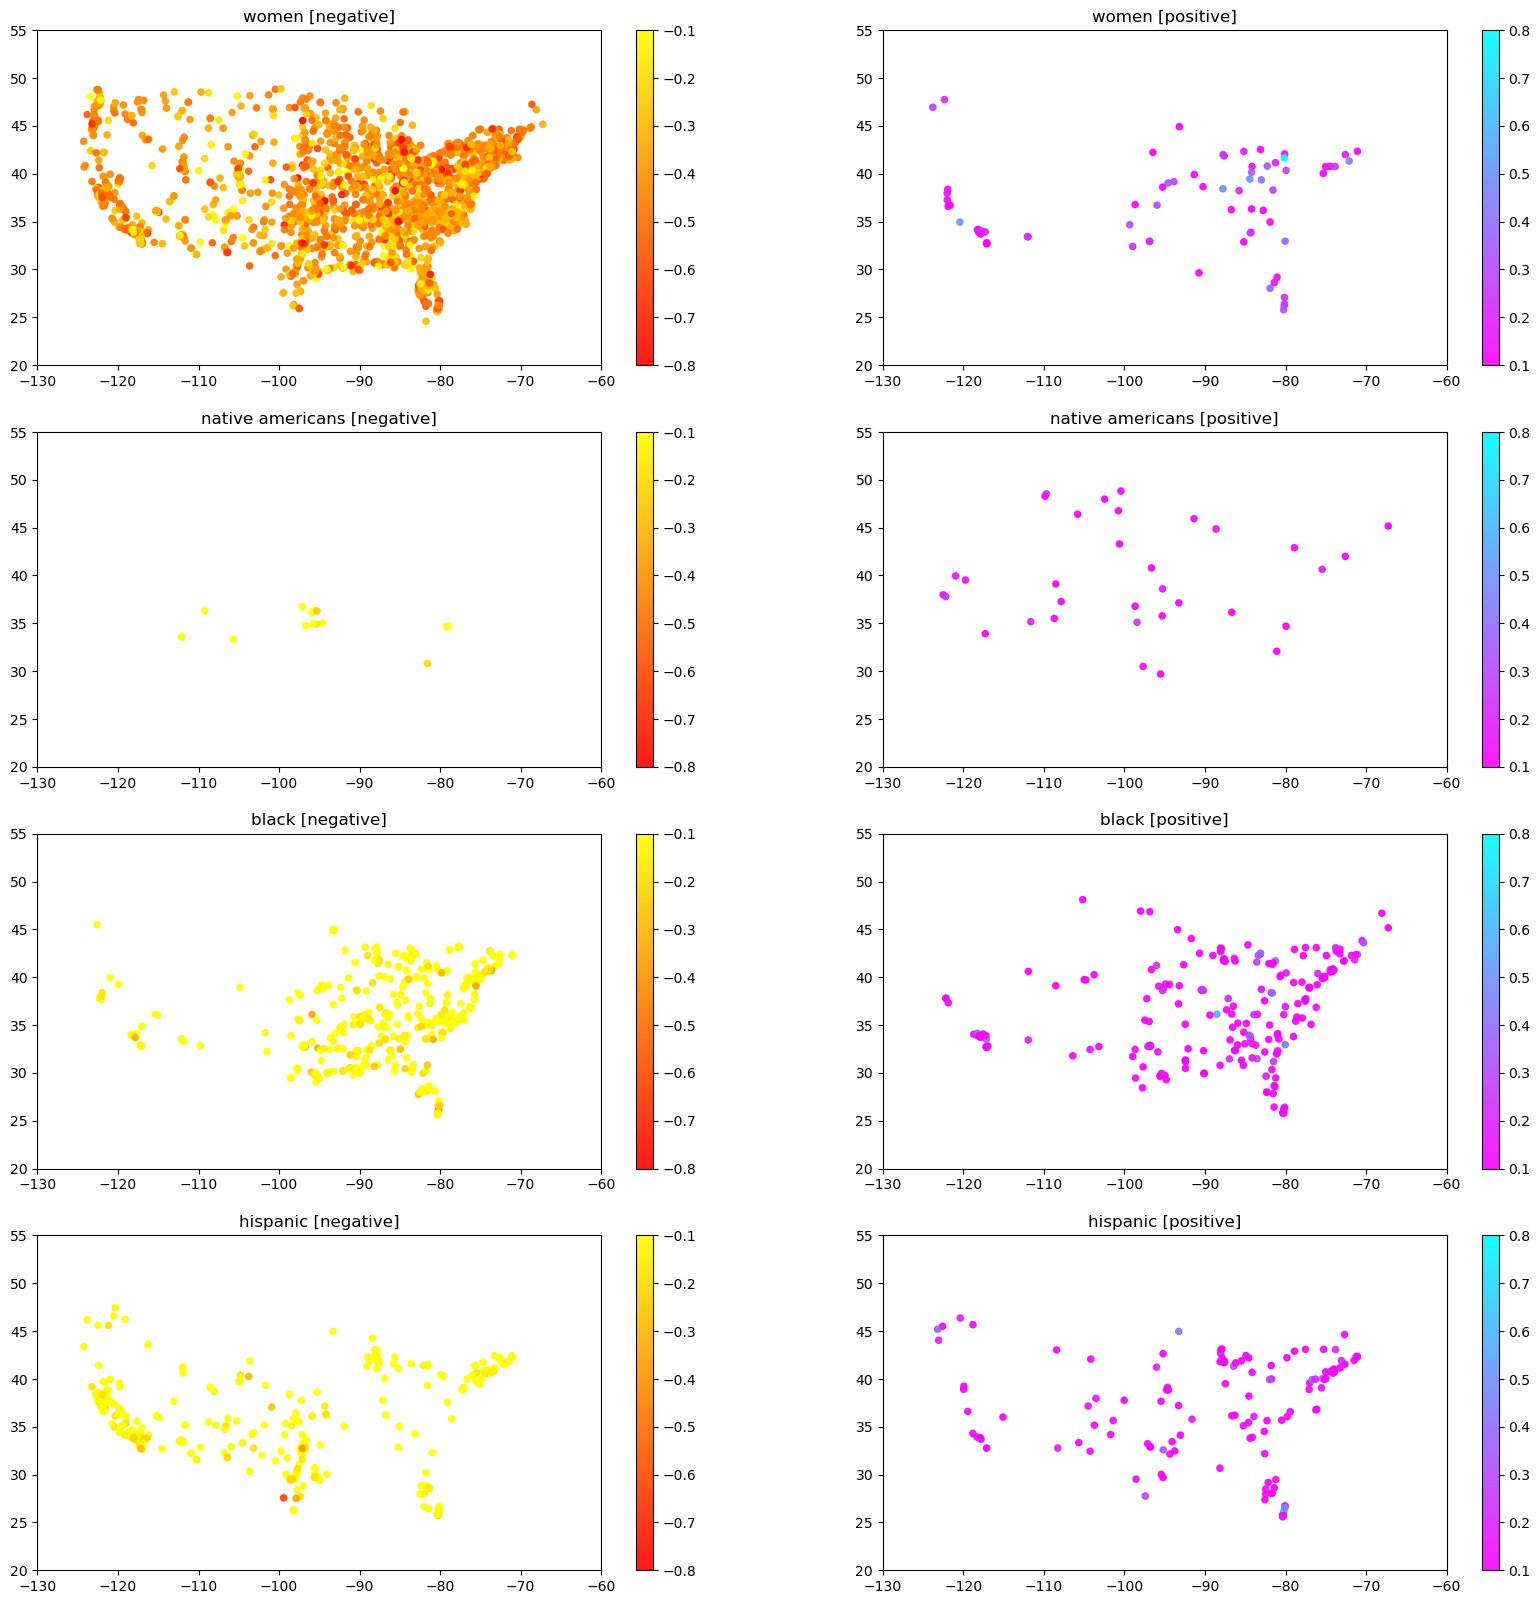

In [16]:
all_averages = all_averages.dropna()

# all_averages.head()
fig, axs = plt.subplots(4, 2, figsize = (20, 20))
demo_cols = all_averages.columns[-5:-1]
labels = ['women', 'native americans', 'black', 'hispanic']
for i, col in enumerate(demo_cols):
    neg = all_averages[all_averages[col] < -0.05]
    pos = all_averages[all_averages[col] > 0.05]
    plot = axs[i][0].scatter(neg['LONGITUD'], neg['LATITUDE'], c=neg[col], cmap='autumn', s=20, vmin=-0.8, vmax=-0.1,\
         alpha = 0.9)
    plt.colorbar(plot, ax=axs[i][0])

    plot = axs[i][1].scatter(pos['LONGITUD'], pos['LATITUDE'], c=pos[col], cmap='cool_r', s=20, vmin=0.1, vmax=0.8, \
        alpha = 0.9)
    plt.colorbar(plot, ax=axs[i][1])
    #plt.(-1, 1)
    axs[i][0].set_xlim(-130, -60)
    axs[i][1].set_xlim(-130, -60)
    axs[i][0].set_ylim(20, 55)
    axs[i][1].set_ylim(20, 55)

    axs[i][0].set_title('%s [negative]' % labels[i])
    axs[i][1].set_title('%s [positive]' % labels[i])
#plt.style.use('dark_background')


In [55]:
demo_cols

Index(['CTOTALW', 'CAIANT', 'CBKAAT', 'CHISPT'], dtype='object')

In [60]:
help(sns.kdeplot)

Help on function kdeplot in module seaborn.distributions:

kdeplot(x=None, *, y=None, shade=None, vertical=False, kernel=None, bw=None, gridsize=200, cut=3, clip=None, legend=True, cumulative=False, shade_lowest=None, cbar=False, cbar_ax=None, cbar_kws=None, ax=None, weights=None, hue=None, palette=None, hue_order=None, hue_norm=None, multiple='layer', common_norm=True, common_grid=False, levels=10, thresh=0.05, bw_method='scott', bw_adjust=1, log_scale=None, color=None, fill=None, data=None, data2=None, warn_singular=True, **kwargs)
    Plot univariate or bivariate distributions using kernel density estimation.
    
    A kernel density estimate (KDE) plot is a method for visualizing the
    distribution of observations in a dataset, analagous to a histogram. KDE
    represents the data using a continuous probability density curve in one or
    more dimensions.
    
    The approach is explained further in the :ref:`user guide <tutorial_kde>`.
    
    Relative to a histogram, KDE can

In [ ]:
regional_difference_mapping(2021, 2021)

/var/folders/b5/xk6gdm191jgfc3mj34jg7zbh0000gn/T/ipykernel_65678/2655918033.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg[col] = neg[col]*-1
/var/folders/b5/xk6gdm191jgfc3mj34jg7zbh0000gn/T/ipykernel_65678/2655918033.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg[col] = neg[col]*-1
/var/folders/b5/xk6gdm191jgfc3mj34jg7zbh0000gn/T/ipykernel_65678/2655918033.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

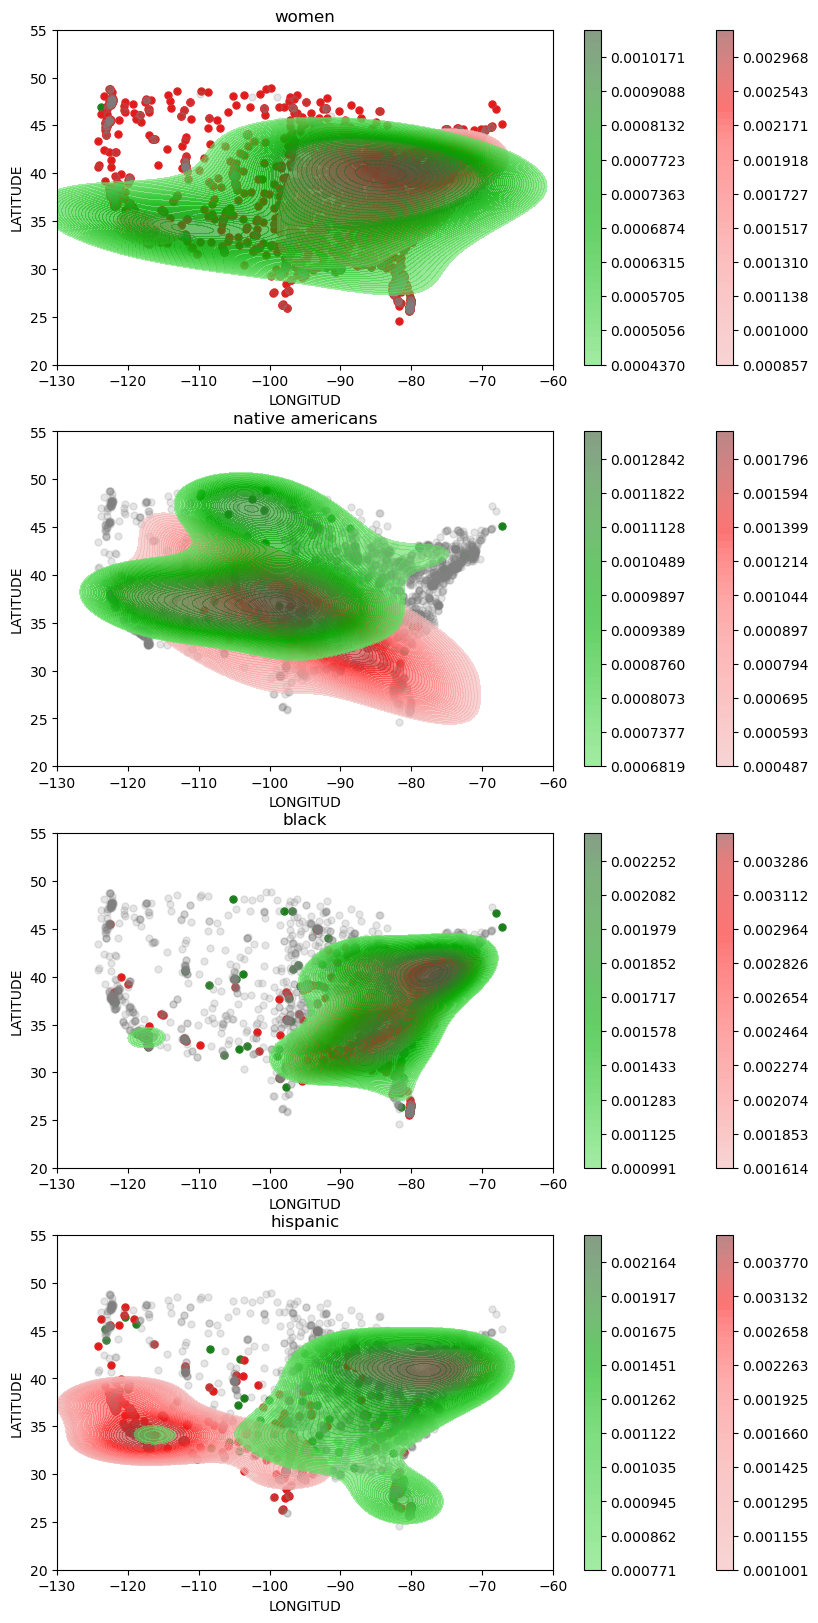

In [37]:
import seaborn as sns

all_averages = all_averages.dropna()

# all_averages.head()
fig, axs = plt.subplots(4, 1, figsize = (10, 20))
demo_cols = all_averages.columns[-5:-1]
labels = ['women', 'native americans', 'black', 'hispanic']
thresh = [0, ]
vmin = []
for i, col in enumerate(demo_cols):
    neg = all_averages[all_averages[col] < -0.05]
    pos = all_averages[all_averages[col] > 0.05]
    plot = axs[i].scatter(pos['LONGITUD'], pos['LATITUDE'], c= 'green', s=25)
    plot = axs[i].scatter(neg['LONGITUD'], neg['LATITUDE'], c= 'red', s=25)
    plot = axs[i].scatter(all_averages['LONGITUD'], all_averages['LATITUDE'], c= 'gray', alpha = 0.2, s=25)
    neg[col] = neg[col]*-1
    sns.kdeplot(data=neg, x='LONGITUD', y='LATITUDE', fill=True, legend=False, ax=axs[i], gridsize=1000, color='red', alpha=0.6, common_grid=True, cbar=True, levels = 50, thresh=0.4)
    # plt.colorbar(plot, ax=axs[i][0])

    # plot = axs[i][1].scatter(pos['LONGITUD'], pos['LATITUDE'], c=pos[col], cmap='cool_r', s=20, vmin=0.1, vmax=0.8, \
    #     alpha = 0.9)
    sns.kdeplot(data=pos, x='LONGITUD', y='LATITUDE', fill=True, legend=False, ax=axs[i], gridsize=1000, color='green', alpha=0.6, common_grid=True, cbar=True, levels = 50, thresh=0.4)
    # plt.colorbar(plot, ax=axs[i][1])
    #plt.(-1, 1)
    axs[i].set_xlim(-130, -60)
    axs[i].set_ylim(20, 55)
    
    axs[i].set_title('%s' % labels[i])
plt.style.use('default')


/var/folders/b5/xk6gdm191jgfc3mj34jg7zbh0000gn/T/ipykernel_65678/1842200604.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg[col] = neg[col]*-1
/var/folders/b5/xk6gdm191jgfc3mj34jg7zbh0000gn/T/ipykernel_65678/1842200604.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg[col] = neg[col]*-1
/var/folders/b5/xk6gdm191jgfc3mj34jg7zbh0000gn/T/ipykernel_65678/1842200604.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

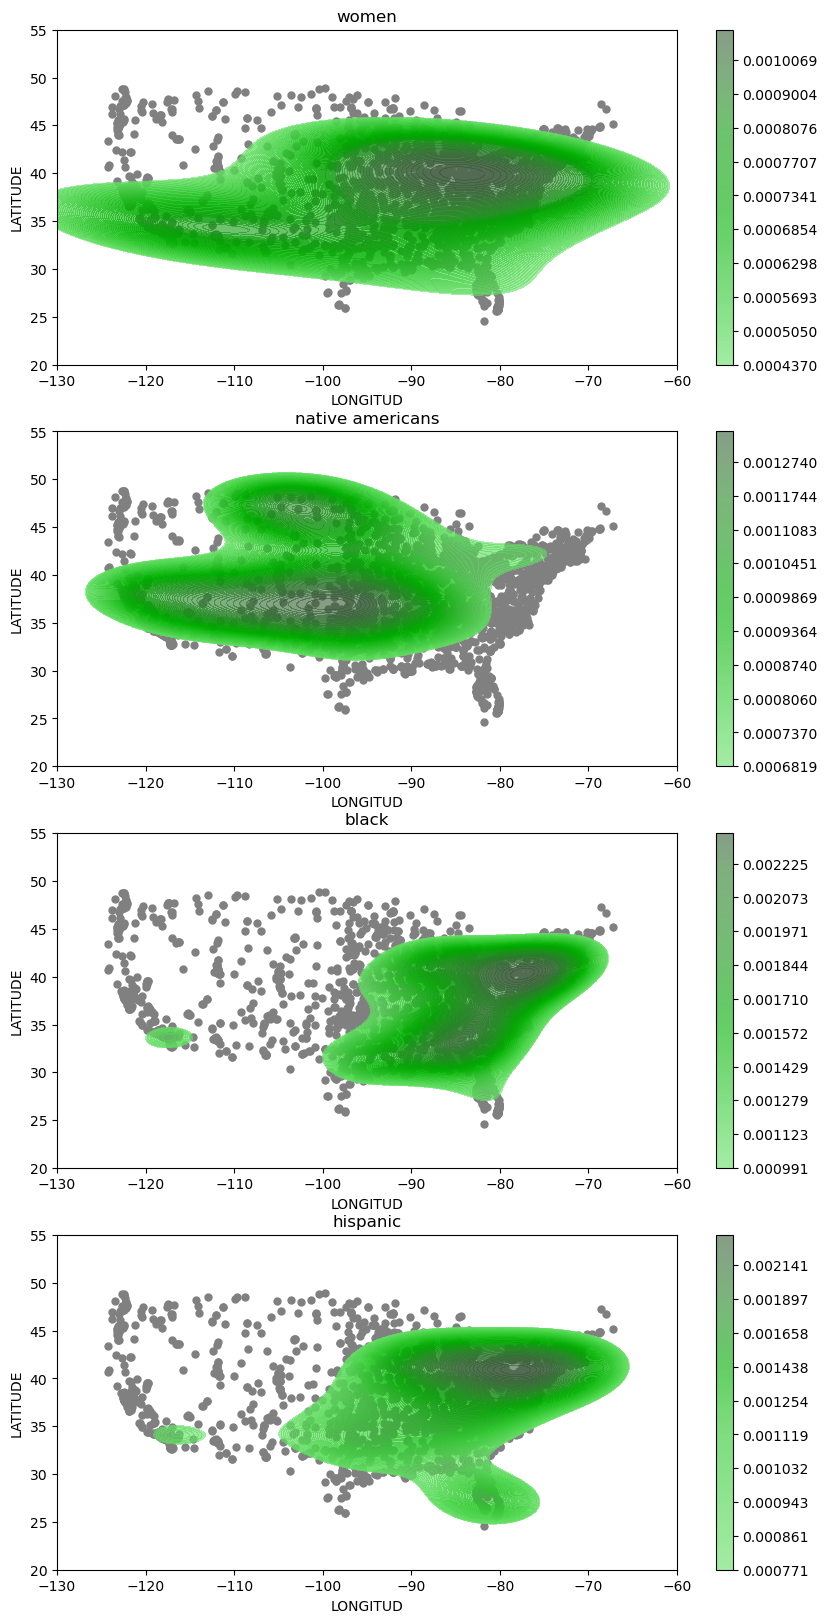

In [35]:
import seaborn as sns

all_averages = all_averages.dropna()

# all_averages.head()
fig, axs = plt.subplots(4, 1, figsize = (10, 20))
demo_cols = all_averages.columns[-5:-1]
labels = ['women', 'native americans', 'black', 'hispanic']
thresh = [0, ]
vmin = []
for i, col in enumerate(demo_cols):
    neg = all_averages[all_averages[col] < -0.05]
    pos = all_averages[all_averages[col] > 0.05]
    plot = axs[i].scatter(all_averages['LONGITUD'], all_averages['LATITUDE'], c= 'gray', s=25)
    neg[col] = neg[col]*-1
    #sns.kdeplot(data=neg, x='LONGITUD', y='LATITUDE', fill=True, legend=False, ax=axs[i], gridsize=1000, color='red', alpha=0.8, common_grid=True, cbar=True, levels = 50, thresh=0.4)
    # plt.colorbar(plot, ax=axs[i][0])

    # plot = axs[i][1].scatter(pos['LONGITUD'], pos['LATITUDE'], c=pos[col], cmap='cool_r', s=20, vmin=0.1, vmax=0.8, \
    #     alpha = 0.9)
    sns.kdeplot(data=pos, x='LONGITUD', y='LATITUDE', fill=True, legend=False, ax=axs[i], gridsize=1000, alpha = 0.6, color='green', common_grid=True, cbar=True, levels = 100, thresh=0.4)
    # plt.colorbar(plot, ax=axs[i][1])
    #plt.(-1, 1)
    axs[i].set_xlim(-130, -60)
    axs[i].set_ylim(20, 55)
    
    axs[i].set_title('%s' % labels[i])
plt.style.use('default')


/var/folders/b5/xk6gdm191jgfc3mj34jg7zbh0000gn/T/ipykernel_65678/3847250330.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg[col] = neg[col]*-1


(77, 8) (2759, 8)


/var/folders/b5/xk6gdm191jgfc3mj34jg7zbh0000gn/T/ipykernel_65678/3847250330.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg[col] = neg[col]*-1


(33, 8) (18, 8)


/var/folders/b5/xk6gdm191jgfc3mj34jg7zbh0000gn/T/ipykernel_65678/3847250330.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg[col] = neg[col]*-1


(218, 8) (420, 8)


/var/folders/b5/xk6gdm191jgfc3mj34jg7zbh0000gn/T/ipykernel_65678/3847250330.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg[col] = neg[col]*-1


(136, 8) (432, 8)


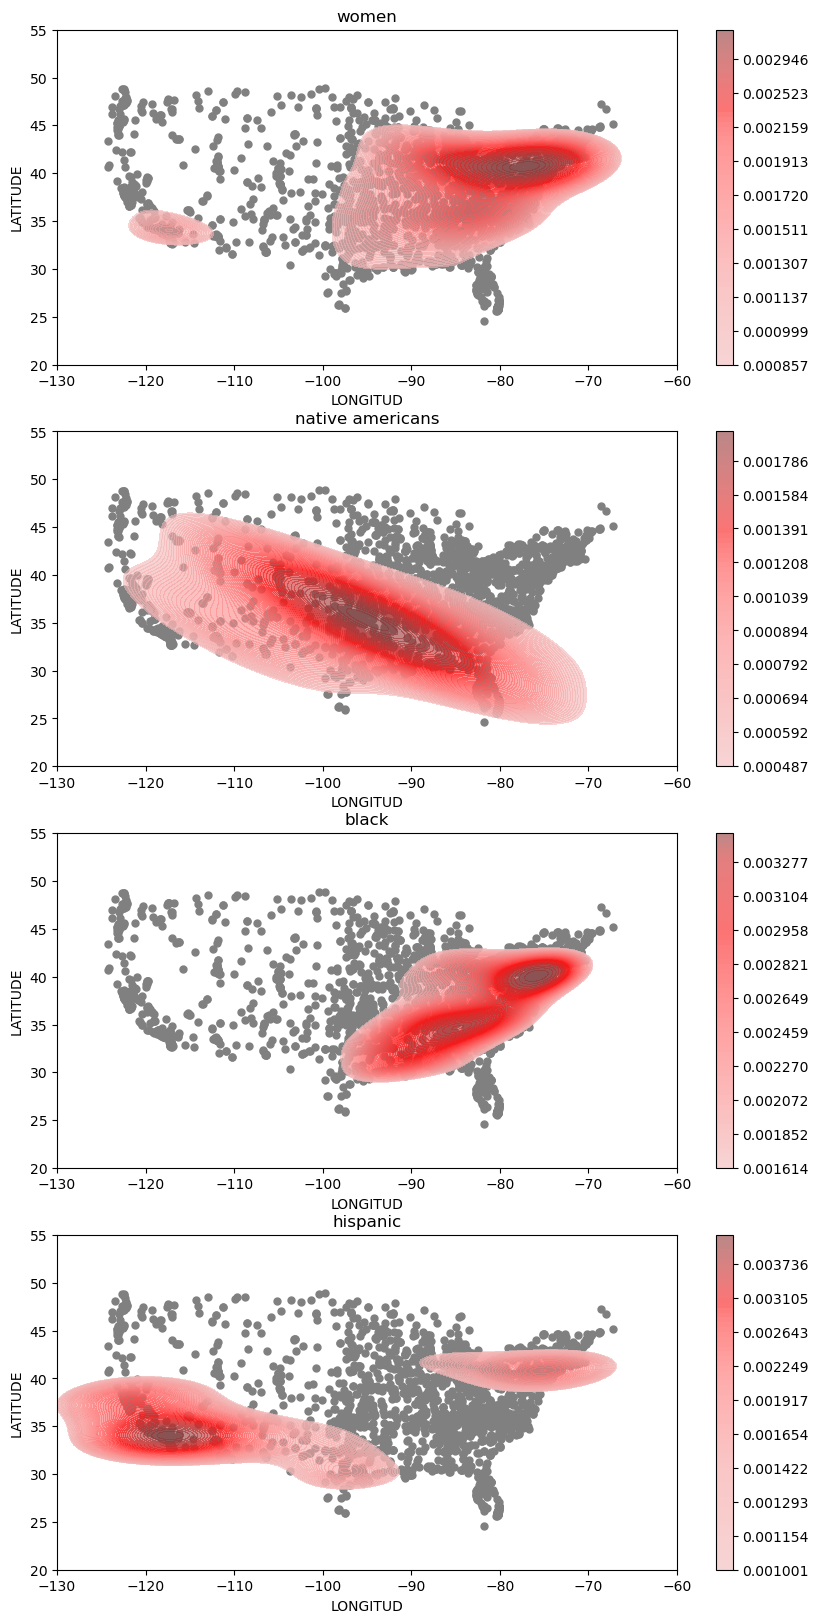

In [32]:
import seaborn as sns

all_averages = all_averages.dropna()

# all_averages.head()
fig, axs = plt.subplots(4, 1, figsize = (10, 20))
demo_cols = all_averages.columns[-5:-1]
labels = ['women', 'native americans', 'black', 'hispanic']
thresh = [0, ]
vmin = []
for i, col in enumerate(demo_cols):
    neg = all_averages[all_averages[col] < -0.05]
    pos = all_averages[all_averages[col] > 0.05]
    plot = axs[i].scatter(all_averages['LONGITUD'], all_averages['LATITUDE'], c= 'gray', s=25)
    neg[col] = neg[col]*-1
    sns.kdeplot(data=neg, x='LONGITUD', y='LATITUDE', fill=True, legend=False, ax=axs[i], gridsize=1000, color='red', common_grid=True, alpha = 0.6, cbar=True, levels = 70, thresh=0.4)
    # plt.colorbar(plot, ax=axs[i][0])

    # plot = axs[i][1].scatter(pos['LONGITUD'], pos['LATITUDE'], c=pos[col], cmap='cool_r', s=20, vmin=0.1, vmax=0.8, \
    #     alpha = 0.9)
    #sns.kdeplot(data=pos, x='LONGITUD', y='LATITUDE', fill=True, legend=False, ax=axs[i], gridsize=1000, color='green', alpha=0.8, common_grid=True, cbar=True, levels = 50, thresh=0.4)
    # plt.colorbar(plot, ax=axs[i][1])
    #plt.(-1, 1)
    axs[i].set_xlim(-130, -60)
    axs[i].set_ylim(20, 55)
    
    axs[i].set_title('%s' % labels[i])
    print(pos.shape, neg.shape)
plt.style.use('default')


/var/folders/b5/xk6gdm191jgfc3mj34jg7zbh0000gn/T/ipykernel_65678/1714990742.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg[col] = neg[col]*-1
/var/folders/b5/xk6gdm191jgfc3mj34jg7zbh0000gn/T/ipykernel_65678/1714990742.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg[col] = neg[col]*-1
/var/folders/b5/xk6gdm191jgfc3mj34jg7zbh0000gn/T/ipykernel_65678/1714990742.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

         LONGITUD   LATITUDE         year   CTOTALW    CAIANT    CBKAAT  \
UNITID                                                                    
128577 -72.570177  41.998409  2016.500000  0.183005  0.070191 -0.093325   
129774 -72.095230  41.328013  2012.000000  0.446154  0.000000  0.000000   
165884 -71.070231  42.346023  2021.000000  0.073444 -0.009852 -0.072100   
186618 -74.438221  40.781820  2016.285714  0.128172 -0.002272  0.133548   
192509 -73.829457  40.760109  2011.000000  0.250000  0.000000  0.000000   
...           ...        ...          ...       ...       ...       ...   
376242 -66.060473  17.970907  2009.500000  0.522581  0.000000  0.000000   
414461 -66.053276  18.237102  2012.000000  0.324821  0.000000  0.000000   
444264 -66.041133  18.222782  2017.000000  0.088136  0.000000  0.000000   
451501 -66.614980  18.010734  2010.000000  0.253241  0.000000  0.000000   
494278 -65.824550  18.150762  2020.000000  0.175000  0.000000  0.000000   

          CHISPT  CTOTAL

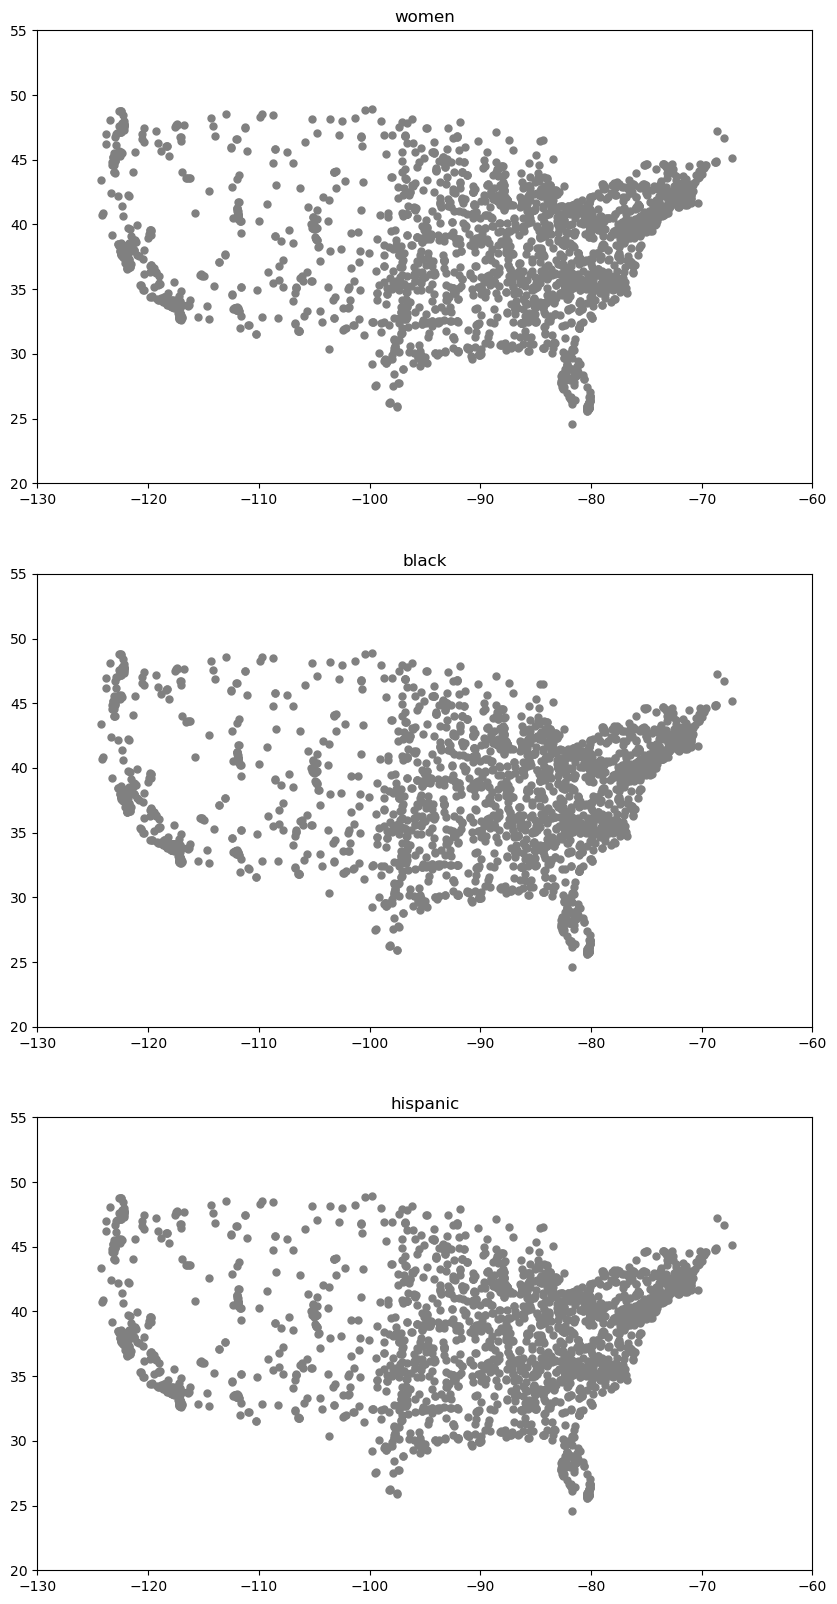

In [72]:
import seaborn as sns

all_averages = all_averages.dropna()

# all_averages.head()
fig, axs = plt.subplots(3, 1, figsize = (10, 20))
demo_cols =['CTOTALW', 'CBKAAT', 'CHISPT']
labels = ['women', 'black', 'hispanic']
thresh = [0, ]
vmin = []
for i, col in enumerate(demo_cols):
    neg = all_averages[all_averages[col] < -0.05]
    pos = all_averages[all_averages[col] > 0.05]
    plot = axs[i].scatter(all_averages['LONGITUD'], all_averages['LATITUDE'], c= 'gray', s=25)
    neg[col] = neg[col]*-1
    #sns.histplot(data=neg, x='LONGITUD', y='LATITUDE', fill=True, legend=False, ax=axs[i], color='red', alpha=0.8, cbar=True, thresh=5, cbar_kws={'vmin': 0, 'vmax': 100})
    #sns.histplot(data=pos, x='LONGITUD', y='LATITUDE', fill=True, legend=False, ax=axs[i], alpha = 0.6, color='green', cbar=True, thresh=5, pmax=1)
    # sns.histplot(data=neg, x='LONGITUD', y='LATITUDE', fill=True, weights = neg[col], legend=False, ax=axs[i], color='red', alpha=0.8, cbar=True, bins=int((len(neg)/50)))
    # sns.histplot(data=pos, x='LONGITUD', y='LATITUDE', fill=True, weights=pos[col], legend=False, ax=axs[i], alpha = 0.6, color='green', cbar=True, bins= int((len(pos) / 5)))
    axs[i].set_xlim(-130, -60)
    axs[i].set_ylim(20, 55)
    
    axs[i].set_title('%s' % labels[i])
    print(pos[:100])
plt.style.use('default')


In [59]:
demo_cols 

Index(['CTOTALW', 'CAIANT', 'CBKAAT', 'CHISPT'], dtype='object')